有監督式學習

原始數據

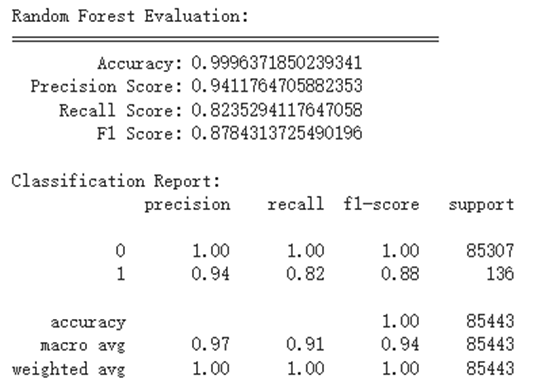

In [3]:
#################################監督式學習(random forest)###################3
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, roc_auc_score,
    precision_recall_curve
)
from xgboost import XGBClassifier
import kagglehub

# 一般設定
RANDOM_SEED = 42
TEST_SIZE = 0.3

# 載入資料
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
data = pd.read_csv(f"{path}/creditcard.csv")
data['Class'] = data['Class'].astype(int)

# 預處理
data.drop(['Time'], axis=1, inplace=True)
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

X = data.drop(columns=['Class']).values
y = data['Class'].values

# 訓練/測試集切分
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED
)

# 建立 XGBoost 模型（無 SMOTE）
xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=7,
    learning_rate=0.1,
    min_child_weight=1,
    gamma=0.2,
    subsample=0.9,
    colsample_bytree=0.9,
    scale_pos_weight=200,  # 根據你資料比例微調。非越大越好
    random_state=RANDOM_SEED,
    eval_metric='logloss'
)

xgb_model.fit(X_train, y_train)

# 預測機率
y_probs = xgb_model.predict_proba(X_test)[:, 1]

# 自動尋找最佳 threshold（以 F1 score 為優先）
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
best_idx = np.argmax(f1_scores)
best_threshold = 0.941

# 使用最佳門檻進行分類
y_pred = (y_probs > best_threshold).astype(int)

# 評估結果
print(f"\n✅ Best Threshold Found: {best_threshold:.3f}")
print(f"Precision: {precision[best_idx]:.4f}")
print(f"Recall:    {recall[best_idx]:.4f}")
print(f"F1 Score:  {f1_scores[best_idx]:.4f}")
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_test, y_probs):.4f}")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


✅ Best Threshold Found: 0.941
Precision: 0.9576
Recall:    0.8309
F1 Score:  0.8898
Accuracy:  0.9997
ROC AUC:   0.9871

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.96      0.83      0.89       136

    accuracy                           1.00     85443
   macro avg       0.98      0.92      0.94     85443
weighted avg       1.00      1.00      1.00     85443



非監督式學習

原始數據

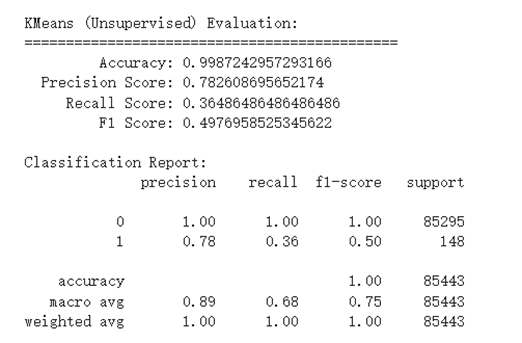
  

In [4]:
#################### K-Means 非監督式學習#####################
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.decomposition import PCA
from scipy.spatial.distance import mahalanobis
import kagglehub

# General settings
RANDOM_SEED = 42
TEST_SIZE = 0.3

# Load dataset
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
data = pd.read_csv(f"{path}/creditcard.csv")
data['Class'] = data['Class'].astype(int)

# Prepare data
data = data.drop(['Time'], axis=1)
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

# Extract features and labels
X = data.drop(columns=['Class']).values
y = data['Class'].values

# Split the dataset
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=y
)

# Scale features
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Hyperparameters
pca_variances = [0.96, 0.97, 0.98]
sample_sizes = [1200, 1500, 1800, 2000]
best_f1 = 0
best_y_pred = None
best_config = {}

# Start grid search
for pca_var in pca_variances:
    pca = PCA(n_components=pca_var, random_state=RANDOM_SEED)
    x_train_pca = pca.fit_transform(x_train)
    x_test_pca = pca.transform(x_test)

    for sample_size in sample_sizes:
        n_x_train = x_train_pca[y_train == 0][:sample_size]
        z_scores = np.abs((n_x_train - n_x_train.mean(axis=0)) / n_x_train.std(axis=0))
        n_x_train = n_x_train[(z_scores < 1.8).all(axis=1)]

        k_range = range(10, 16)
        scores = []
        for k in k_range:
            kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=500, random_state=RANDOM_SEED)
            kmeans.fit(n_x_train)
            scores.append(silhouette_score(n_x_train, kmeans.labels_))

        optimal_k = k_range[np.argmax(scores)]
        kmeans = KMeans(n_clusters=optimal_k, init='k-means++', max_iter=500, random_state=RANDOM_SEED)
        kmeans.fit(n_x_train)

        cov_matrix = np.cov(n_x_train.T)
        inv_cov_matrix = np.linalg.pinv(cov_matrix)
        centroids = kmeans.cluster_centers_

        def min_mahalanobis_distance(x, centroids, inv_cov):
            return min([mahalanobis(x, c, inv_cov) for c in centroids])

        min_distances = np.array([min_mahalanobis_distance(x, centroids, inv_cov_matrix) for x in x_test_pca])
        min_distances = (min_distances - np.median(min_distances)) / (
            np.percentile(min_distances, 75) - np.percentile(min_distances, 25))

        percentiles = np.arange(99.85, 99.99, 0.002)
        for perc in percentiles:
            threshold = np.percentile(min_distances, perc)
            y_pred = (min_distances > threshold).astype(int)
            precision = precision_score(y_test, y_pred, zero_division=0)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            score = 0.85 * precision + 0.15 * recall

            if f1 > best_f1:
                best_f1 = f1
                best_y_pred = y_pred
                best_config = {
                    'pca_var': pca_var,
                    'sample_size': sample_size,
                    'k': optimal_k,
                    'threshold': round(threshold, 4)
                }

# Final evaluation
def evaluation(y_true, y_pred, model_name="Model"):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f'\n{model_name} Evaluation:')
    print('===' * 15)
    print(f'         Accuracy: {accuracy:.4f}')
    print(f'  Precision Score: {precision:.4f}')
    print(f'     Recall Score: {recall:.4f}')
    print(f'         F1 Score: {f1:.4f}')
    print(f'Best Configuration: {best_config}')
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

# Evaluate
evaluation(y_test, best_y_pred, model_name="KMeans (Ultra Fine-Tuned Mahalanobis)")



KMeans (Ultra Fine-Tuned Mahalanobis) Evaluation:
         Accuracy: 0.9993
  Precision Score: 0.8295
     Recall Score: 0.7230
         F1 Score: 0.7726
Best Configuration: {'pca_var': 0.97, 'sample_size': 1200, 'k': 14, 'threshold': np.float64(355.752)}

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.83      0.72      0.77       148

    accuracy                           1.00     85443
   macro avg       0.91      0.86      0.89     85443
weighted avg       1.00      1.00      1.00     85443

